# TODO's for thesis

In [1]:
%cd ..
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from tqdm import tqdm
import soundfile as sf

## Load all samples into memory if possible

In [2]:
# For now let's focus on a subset of the dataset for testing
wav_files = glob.glob('audio/EvoMix-NormalizedSamples/Normalized/Archive/SingleInstrumentSamples/**/*.wav', recursive=True)
wav_files
instrument_names = set()
notes = set()
samples = dict()
for path in tqdm(wav_files):
    # Load wave file
    y = librosa.load(path)

    # Get instrument name, style and note from file path
    instrument_name, tail = path.split(
        "ForMixing\\")[1].split("\\", maxsplit=1)
    instrument_names.add(instrument_name)
    style, tail = tail.split("\\")[-2:]
    note = tail.split("_")[-1].split(".")[0]
    notes.add(note)

    # Save in sample dictionary
    if instrument_name not in samples:
        samples[instrument_name] = {style: {note: y}}
    else:
        if style not in samples[instrument_name]:
            samples[instrument_name][style] = {note: y}
        else:
            samples[instrument_name][style][note] = y


100%|██████████| 2227/2227 [00:05<00:00, 406.46it/s]


In [3]:
import threading
# Multithreaded loading
wav_files = glob.glob('audio/EvoMix-NormalizedSamples/Normalized/Archive/SingleInstrumentSamples/**/*.wav', recursive=True)
wav_files
instrument_names = set()
notes = set()
samples = dict()

class LoadingThread(threading.Thread):
    def __init__(self, threadID, name, filepaths):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
        self.filepaths = filepaths
    
    def run(self):
        print("Starting " + self.name)
        for i, filepath in enumerate(self.filepaths):
            load_file(filepath)
            if i % 50 == 0:
                print(f"{self.threadID}: Progress: {i}")

def load_file(path):
    # Load wave file
    y = librosa.load(path)

    # Get instrument name, style and note from file path
    instrument_name, tail = path.split("ForMixing\\")[1].split("\\", maxsplit=1)
    instrument_names.add(instrument_name)
    style, tail = tail.split("\\")[-2:]
    note = tail.split("_")[-1].split(".")[0].capitalize()
    notes.add(note)

    # Save in sample dictionary
    if instrument_name not in samples:
        samples[instrument_name] = {style: {note: y}}
    else:
        if style not in samples[instrument_name]:
            samples[instrument_name][style] = {note: y}
        else:
            samples[instrument_name][style][note] = y
    return True

n_threads = 8
threads = [LoadingThread(i, f"Thread-{i}", wav_files[(i*round(len(wav_files)/n_threads)):(i+1)*round(len(wav_files)/n_threads)]) for i in range(n_threads)]
for thread in threads:
    thread.start()

for t in threads:
    t.join()

print("Done")

Starting Thread-0
Starting Thread-1
Starting Thread-2
Starting Thread-3
Starting Thread-4
Starting Thread-5
Starting Thread-6
Starting Thread-7
Done


In [3]:
samples['ElectricGuitar']['tr131EGLFM']['E2'][0] # Waveform y
#samples['ElectricGuitar']['tr131EGLFM']['E2'][1] # Sample Rate sr

array([0.0004463 , 0.00174319, 0.00302309, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [4]:
# Test for sample rates
seen_sr = set()
for instrument in samples:
    for style in samples[instrument]:
        for note in samples[instrument][style]:
            seen_sr.add(samples[instrument][style][note][1])

## Establish data structure for a genotype

In [5]:
# Individuals in the base algorithm are sets of 3-tuples of (instrument, style, pitch)
example_individual = [('ElectricGuitar', 'tr131EGLFM', 'E2'), ('ElectricGuitar', 'tr131EGLFM', 'B3'), ('Flute', 'tr331FLNOM', 'E6')]

# Function to turn an individual into a sound (Creation of phenotype)
def get_mixdown(genotype: list):
    ys = [np.array(samples[instrument][style][pitch][0]) for (instrument, style, pitch) in genotype]
    max_length = np.max([len(y) for y in ys])
    for y in ys:
        y.resize(max_length, refcheck=False)
    ys_equal_length = np.array(ys)

    output = np.sum(ys_equal_length, axis=0)
    return output

mix = get_mixdown(example_individual)
#sf.write("mixtest.wav", mix, 22050, subtype='PCM_24')

## Write fitness function between phenotype and ground truth

C:\Users\justi\AppData\Local\Temp\ipykernel_9132\2383614785.py:7: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  img = librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max),
C:\Users\justi\AppData\Local\Temp\ipykernel_9132\2383614785.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


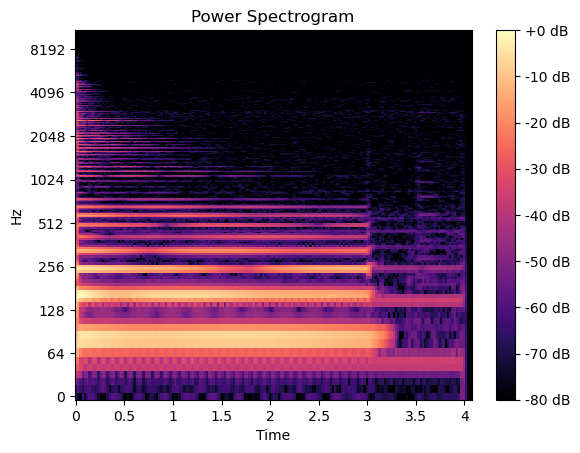

In [6]:
# Testing
import librosa.display
y = get_mixdown([('ElectricGuitar', 'tr131EGLFM', 'E2')])
stft = librosa.stft(y)

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max),
    y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power Spectrogram')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
fig.show()

C:\Users\justi\AppData\Local\Temp\ipykernel_9132\3556576603.py:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  img = librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max),
C:\Users\justi\AppData\Local\Temp\ipykernel_9132\3556576603.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


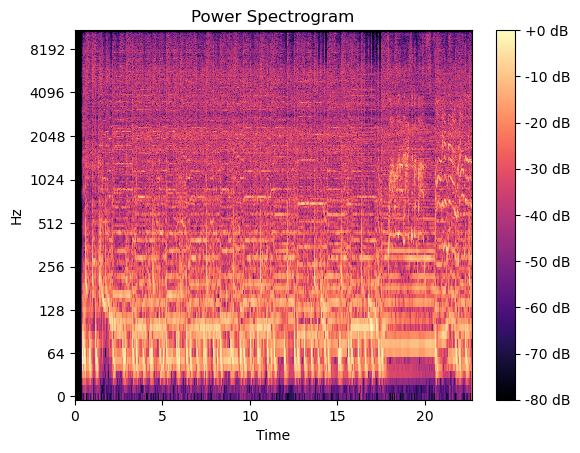

In [7]:
import librosa.display
y, sr = librosa.load("G:/Redefined/FRAGMENTS PRODUCTION/Master/v306/ReDefined - Fragments - Master 306-3 - 03 Trail In The Sky.mp3")
stft = librosa.stft(y[:500000])

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max),
    y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power Spectrogram')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
fig.show()

C:\Users\justi\AppData\Local\Temp\ipykernel_9132\974453642.py:7: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  img = librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max),
C:\Users\justi\AppData\Local\Temp\ipykernel_9132\974453642.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


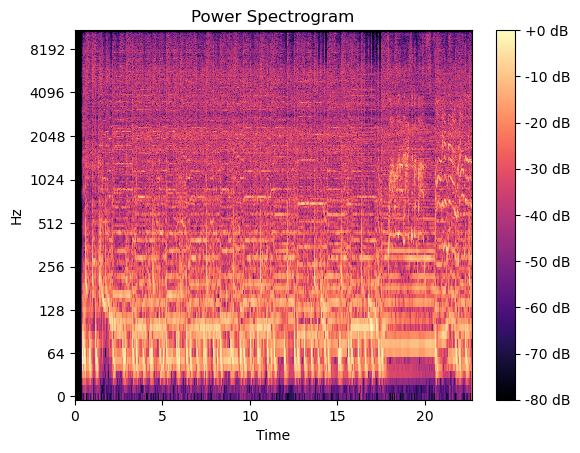

In [8]:
# Testing
import librosa.display
y = get_mixdown([('ElectricGuitar', 'tr131EGLFM', 'Gis2')])
stft_2 = librosa.stft(y)

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max),
    y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power Spectrogram')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
fig.show()

# Fitness Function

In [9]:
def cosh_distance(x, y):
    a = np.average(abs(x), axis=1)
    b = np.average(abs(y), axis=1)
    return np.sum(a/b - np.log(a/b) + b/a - np.log(b/a) - 2) / len(a)

In [10]:
a = abs(stft[:, 60])
b = abs(stft_2[:, 60])
np.sum(a/b - np.log(a/b) + b/a - np.log(b/a) - 2) / len(a)

2220.6553658536586

In [11]:
y = get_mixdown([('AcousticGuitar', 'tr111AGAFM', 'G2')])
stft_3 = librosa.stft(y)
c = abs(stft_3[:, 60])
np.sum(a/c - np.log(a/c) + c/a - np.log(c/a) - 2) / len(a)

6024.666341463415

In [12]:
stft.shape

(1025, 977)

In [13]:
y = get_mixdown([('ElectricGuitar', 'tr131EGLFM', 'E2')]) * 1.5
stft_louder = librosa.stft(y)

In [14]:
dist1 = cosh_distance(stft, stft_2)
dist2 = cosh_distance(stft, stft_3)
dist1, dist2

(722.2616463414635, 450.9428353658537)

In [15]:
dist_louder = cosh_distance(stft, stft_louder)
dist_louder

416.65704268292683

## Placeholder random individual generation

In [16]:
def get_random_genotype():
    # Get random instrument
    instruments = list(samples.keys())
    instrument = instruments[np.random.randint(len(instruments))]

    # Get random style
    styles = list(samples[instrument].keys())
    style = styles[np.random.randint(len(styles))]

    # Get random key
    keys = list(samples[instrument][style].keys())
    key = keys[np.random.randint(len(keys))]

    return (instrument, style, key)

def get_random_genotype_multitrack():
    N_MAX = 5
    n_tracks = np.random.choice(N_MAX+1, p=[0, 0.1, 0.3, 0.3, 0.2, 0.1]) # Vatolkin et. al. (2021)
    multitrack = []
    for i in range(n_tracks):
        multitrack.append(get_random_genotype())
    return multitrack

In [49]:
%timeit get_random_genotype()
%timeit get_random_genotype_multitrack()

10.8 µs ± 54.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
52.4 µs ± 205 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [50]:
%timeit cosh_distance(target, mix)

8.6 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
a = librosa.stft(target)
b = librosa.stft(mix)
%timeit cosh_distance(a, librosa.stft(mix))

5.75 ms ± 93.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Basic algo as quasi-random search 

Single Instrument

In [17]:
target = get_mixdown([('ElectricGuitar', 'tr131EGLFM', 'E2')])
target_stft = librosa.stft(target)

# Random Search Loop
N = 1000
# init
best = get_random_genotype()
best_fitness = cosh_distance(target_stft, librosa.stft(get_mixdown([best])))
for n in tqdm(range(N)):
    candidate = get_random_genotype()
    candidate_fitness = cosh_distance(target_stft, librosa.stft(get_mixdown([candidate])))
    if candidate_fitness < best_fitness:
        best = candidate
        best_fitness = candidate_fitness
        print(f"New best individual found: {best} with fitness {best_fitness}")

  1%|▏         | 13/1000 [00:00<00:08, 118.18it/s]

New best individual found: ('AcousticGuitar', 'tr113AGAPM', 'Ais4') with fitness 14.916033727134147
New best individual found: ('Piano', 'tr012PFPM', 'c5') with fitness 3.821239519817073
New best individual found: ('Piano', 'tr013PFNOM', 'Ais4') with fitness 3.781544159679878
New best individual found: ('ElectricGuitar', 'tr133EGLFM', 'A2') with fitness 2.575384432164634


 11%|█▏        | 113/1000 [00:00<00:05, 156.24it/s]

New best individual found: ('ElectricGuitar', 'tr133EGLPM', 'Gis2') with fitness 2.4764181592987806
New best individual found: ('ElectricGuitar', 'tr132EGVPM', 'F2') with fitness 1.8691349085365854


 20%|██        | 201/1000 [00:01<00:04, 162.95it/s]

New best individual found: ('ElectricGuitar', 'tr131EGLFM', 'D3') with fitness 1.7022615758384145


 54%|█████▍    | 544/1000 [00:03<00:02, 168.20it/s]

New best individual found: ('ElectricGuitar', 'tr131EGLFM', 'G2') with fitness 1.4848279106326219


100%|██████████| 1000/1000 [00:06<00:00, 162.04it/s]


Multitrack

In [18]:
target = get_mixdown([('ElectricGuitar', 'tr131EGLFM', 'E2'), ('ElectricGuitar', 'tr131EGLFM', 'B3'), ('ElectricGuitar', 'tr131EGLFM', 'E3')])
target_stft = librosa.stft(target)

# Random Search Loop
N = 10000
# init
best = get_random_genotype_multitrack()
best_fitness = cosh_distance(target_stft, librosa.stft(get_mixdown(best)))
for n in tqdm(range(N)):
    candidate = get_random_genotype_multitrack()
    candidate_fitness = cosh_distance(target_stft, librosa.stft(get_mixdown(candidate)))
    if candidate_fitness < best_fitness:
        best = candidate
        best_fitness = candidate_fitness
        print(f"New best individual found: {best} with fitness {best_fitness}")

  0%|          | 14/10000 [00:00<01:19, 125.56it/s]

New best individual found: [('Viola', 'tr162VLNVM', 'C4'), ('AcousticGuitar', 'tr113AGAPM', 'D3')] with fitness 7.133633765243903
New best individual found: [('Viola', 'tr161VLNVM', 'Ais3'), ('ElectricGuitar', 'tr131EGVFM', 'C3'), ('AcousticGuitar', 'tr111AGRPM', 'A3')] with fitness 3.7351436261432926
New best individual found: [('ElectricGuitar', 'tr131EGVFM', 'Ais3'), ('Piano', 'tr013PFPEM', 'G2'), ('Piano', 'tr013PFPEM', 'D4')] with fitness 3.107824885670732


  1%|          | 71/10000 [00:00<01:44, 94.87it/s] 

New best individual found: [('Piano', 'tr013PFPEM', 'Fis4'), ('AcousticGuitar', 'tr112AGAPM', 'B3'), ('Flute', 'tr331FLNOM', 'D6')] with fitness 2.932211794969512
New best individual found: [('ElectricGuitar', 'tr132EGVFM', 'Fis2'), ('ElectricGuitar', 'tr131EGLPM', 'B3')] with fitness 2.7667087461890243


  2%|▏         | 169/10000 [00:01<01:24, 116.48it/s]

New best individual found: [('Piano', 'tr011PFNOM', 'e3'), ('ElectricGuitar', 'tr133EGLFM', 'Gis4')] with fitness 2.1114853277439023


  2%|▏         | 193/10000 [00:01<01:28, 110.58it/s]

New best individual found: [('ElectricGuitar', 'tr131EGLFM', 'E3'), ('AcousticGuitar', 'tr111AGAFM', 'E2')] with fitness 1.1483485375381097


 19%|█▊        | 1854/10000 [00:16<01:10, 115.85it/s]

New best individual found: [('ElectricGuitar', 'tr133EGLFM', 'E2'), ('ElectricGuitar', 'tr131EGLFM', 'D3')] with fitness 0.9941519388338415


 39%|███▊      | 3868/10000 [00:34<00:54, 113.52it/s]


KeyboardInterrupt: 

## Functions for basic mutations

In [19]:
from copy import deepcopy

def single_mutate(genotype:list):
    # Decide which mutation to apply
    mutation = np.random.choice([mutate_n_samples, mutate_instrument, mutate_pitch], p=[0.2, 0.4, 0.4])
    # Apply mutation
    mutated_genotype = mutation(genotype)
    # Return mutated genotype
    return mutated_genotype

def mutate_n_samples(genotype:list):
    INCREASE_PROBABILITIES = [1, 0.8, 0.4, 0.1, 0] # for 1, 2, 3, 4 or 5 samples currently present
    pre_mutation_n_samples = len(genotype)
    increase_probability = INCREASE_PROBABILITIES[pre_mutation_n_samples - 1]
    copied_genotype = deepcopy(genotype)
    # Increase or decrease number of samples
    rnd = np.random.random()
    if rnd < increase_probability:
        # Add a sample
        new_sample = get_random_genotype()
        copied_genotype.append(new_sample)
    else:
        # Remove a sample
        idx = np.random.choice(pre_mutation_n_samples)
        copied_genotype.pop(idx)
    return copied_genotype

def mutate_instrument(genotype:list):
    pre_mutation_n_samples = len(genotype)
    copied_genotype = deepcopy(genotype)

    # Choose one instrument
    change_idx = np.random.choice(pre_mutation_n_samples)
    pitch = genotype[change_idx][2] 

    # Randomly change it
    new_instrument, new_style, _ = get_random_genotype()
    
    # See if old pitch exists for new instrument
    if pitch in samples[new_instrument][new_style]:
        # If exists, put into mutated genotype
        copied_genotype[change_idx] = (new_instrument, new_style, pitch)
    else:
        # TODO: Ask how to handle this case
        # For now just go up/down octaves until we find an existing sample
        found = False
        going_down = True
        attempts = 0
        while attempts < 10: # TODO: Make sure this cant infinite loop
            pitch_number = int(pitch[-1])
            if going_down:
                pitch = pitch[:-1] + str(pitch_number - 1)
            else:
                pitch = pitch[:-1] + str(pitch_number + 1)
            if pitch in samples[new_instrument][new_style]:
                copied_genotype[change_idx] = (new_instrument, new_style, pitch)
                found = True
                break
            if pitch_number == 0:
                going_down = False
            attempts += 1
        if attempts > 10:
            print(f"Failed to find valid pitch for {(new_instrument, new_style, pitch)}")

    return copied_genotype

def mutate_pitch(genotype:list):
    pre_mutation_n_samples = len(genotype)
    copied_genotype = deepcopy(genotype)

    # Choose one instrument
    change_idx = np.random.choice(pre_mutation_n_samples)
    chosen_sample = genotype[change_idx]
    
    # Choose a new pitch
    new_pitch = np.random.choice(list(samples[chosen_sample[0]][chosen_sample[1]].keys()))
    copied_genotype[change_idx] = (chosen_sample[0], chosen_sample[1], new_pitch)

    return copied_genotype

In [21]:
test = get_random_genotype_multitrack()
print(test)
test_mutated = mutate_pitch(test)
test, test_mutated

[('AcousticGuitar', 'tr112AGAFM', 'B2'), ('ElectricGuitar', 'tr132EGLPM', 'C5'), ('Cello', 'tr171VCNVM', 'Fis3'), ('Violin', 'tr153VNNVM', 'C6')]


([('AcousticGuitar', 'tr112AGAFM', 'B2'),
  ('ElectricGuitar', 'tr132EGLPM', 'C5'),
  ('Cello', 'tr171VCNVM', 'Fis3'),
  ('Violin', 'tr153VNNVM', 'C6')],
 [('AcousticGuitar', 'tr112AGAFM', 'B2'),
  ('ElectricGuitar', 'tr132EGLPM', 'G2'),
  ('Cello', 'tr171VCNVM', 'Fis3'),
  ('Violin', 'tr153VNNVM', 'C6')])

In [22]:
# Random search with mutation (aka 1+1 ES)
# target = get_mixdown([('AcousticGuitar', 'tr112AGAPM', 'C3'),
#  ('AcousticGuitar', 'tr112AGRFM', 'E3')])
target_gene = get_random_genotype_multitrack()
target = get_mixdown(target_gene)
target_stft = librosa.stft(target)
print(f"Target: {target_gene}")
# Random Search Loop
N = 10000
# init
best = get_random_genotype_multitrack()
best_fitness = cosh_distance(target_stft, librosa.stft(get_mixdown(best)))
for n in (pbar := tqdm(range(N))):
    candidate = single_mutate(best)
    candidate_fitness = cosh_distance(target_stft, librosa.stft(get_mixdown(candidate)))
    if candidate_fitness <= best_fitness:
        best = candidate
        best_fitness = candidate_fitness
        pbar.set_postfix_str('\t' * 100 + f"Best individual: {best} with fitness {best_fitness}")
    if best_fitness <= 0.001:
      break

Target: [('Cello', 'tr171VCSOM', 'Fis3'), ('Flute', 'tr331FLNOM', 'Fis6'), ('Viola', 'tr161VLNOM', 'A4')]


 21%|██        | 2053/10000 [00:10<00:41, 191.10it/s, 																																																																																																				Best individual: [('Cello', 'tr171VCSOM', 'Fis3'), ('Viola', 'tr161VLNOM', 'A4'), ('Flute', 'tr331FLNOM', 'Fis6')] with fitness -2.3260349180640244e-09]                                         


## Onset detection of a piece

In [71]:
# Get file path to audio example
filename = librosa.example('nutcracker')

# Load audio as waveform 'y'
# Store sampling rate as 'sr'
y, sr = librosa.load(filename)

onsets = librosa.onset.onset_detect(y=y, sr=sr)
onset_subset = np.random.choice(onsets, size=round(len(onsets)*0.1)) # phi=10% as per Vatolkin et al (2022)
onset_subset

array([ 646, 4770, 3508, 3431, 3878, 3521, 4195, 4817,  577, 1459, 1711,
       3110, 2498,   74, 3290, 1174, 2215,  577, 3344, 2346, 3952, 4680,
        831, 3019, 4961, 3421, 4435, 4364, 3928, 2537, 3120,  507],
      dtype=int64)

In [78]:
librosa.onset.onset_detect(y=samples['AcousticGuitar']['tr111AGAFM']['A2'][0])

array([  3,  37, 112, 173, 194, 207, 215, 220], dtype=int64)

In [77]:
librosa.onset.onset_detect(y=samples['AcousticGuitar']['tr111AGAFM']['A2'][0], backtrack=True)

array([  2,  36, 110, 171, 192, 204, 213, 217])

In [76]:
librosa.onset.onset_detect(y=y, backtrack=True)

array([  49,   73,   98,  122,  147,  171,  195,  219,  244,  268,  293,
        317,  342,  366,  390,  411,  437,  458,  470,  480,  505,  528,
        552,  575,  584,  596,  618,  631,  643,  667,  677,  689,  713,
        725,  737,  749,  757,  807,  828,  853,  875,  897,  921,  943,
        955,  968,  990, 1000, 1011, 1036, 1047, 1059, 1083, 1103, 1128,
       1157, 1172, 1177, 1198, 1210, 1223, 1244, 1270, 1293, 1318, 1340,
       1366, 1389, 1413, 1434, 1455, 1468, 1479, 1502, 1531, 1542, 1549,
       1571, 1591, 1615, 1663, 1685, 1708, 1753, 1769, 1778, 1802, 1826,
       1850, 1862, 1868, 1874, 1898, 1931, 1955, 1967, 1979, 2003, 2016,
       2026, 2038, 2050, 2062, 2084, 2093, 2100, 2107, 2115, 2129, 2144,
       2152, 2160, 2175, 2189, 2197, 2206, 2212, 2219, 2227, 2263, 2344,
       2448, 2456, 2472, 2481, 2486, 2495, 2519, 2535, 2541, 2551, 2558,
       2565, 2579, 2589, 2597, 2611, 2620, 2628, 2635, 2690, 2715, 2725,
       2761, 2784, 2794, 2806, 2816, 2852, 2907, 29

## Full algo from Igor's paper

## Optimization for Multithreading
If population sizes should be increased, it could make sense to have multiple threads for mutations and fitness evaluations